In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from ncmcm.bundlenet.bundlenet import BunDLeNet, train_model
from ncmcm.bundlenet.utils import prep_data, timeseries_train_test_split
from ncmcm.visualisers.latent_space import LatentSpaceVisualiser
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch

In [26]:
algorithm = 'BunDLeNet_HPO'
rat_name = 'cicero' # ['achilles', 'gatsby','cicero', 'buddy']
data = np.load(f'../../data/raw/rat_hippocampus/{rat_name}.npz')
x, b = data['x'], data['b']
x = x - np.min(x)


In [3]:
def train_bundlenet(config):    
    # Extract hyperparameters from the config dictionary
    learning_rate = config["learning_rate"]
    latent_dim = int(config["latent_dim"])
    n_epochs = int(config["n_epochs"])
    win = int(config["win"])
    
    x_, b_ = prep_data(x, b, win=win)

    x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)

    model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_train_1.shape[1])

    train_history, test_history = train_model(
        x_train,
        b_train_1,
        model,
        b_type='continuous',
        gamma=0.9,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        initialisation= (5, 20),
        validation_data=(x_test, b_test_1),
    )

    # Report validation loss (or another metric) back to Ray Tune
    train.report({"val_loss": test_history[-1, -1]})

In [5]:
search_space = {
    "win": tune.loguniform(1, 50),
    "learning_rate": tune.loguniform(1e-5, 1e-1),
    "latent_dim": tune.uniform(1,10),
    "n_epochs": tune.uniform(10, 500)
}

scheduler = ASHAScheduler(metric="val_loss", mode="min", max_t=500, grace_period=20, reduction_factor=2)
search_algo = BayesOptSearch(metric="val_loss", mode="min")


tuner = tune.Tuner(
    tune.with_parameters(train_bundlenet),
    tune_config=tune.TuneConfig(
        search_alg=search_algo,
        num_samples=100,
        scheduler=scheduler,
        max_concurrent_trials=2, 
    ),
    param_space=search_space,
)
results = tuner.fit()

2024-09-11 14:56:48,894	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-09-11 14:56:48,900	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/akshey/ray_results/train_bundlenet_2024-09-11_14-53-30' in 0.0042s.
2024-09-11 14:56:58,928	INFO tune.py:1041 -- Total run time: 208.33 seconds (198.11 seconds for the tuning loop).
2024-09-11 14:56:58,930	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/home/akshey/ray_results/train_bundlenet_2024-09-11_14-53-30", trainable=...)


In [39]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print("Minimum validation loss:", best_result.metrics['val_loss'])
print("Best hyperparameters found were: ", best_result.config)


Minimum validation loss: 0.0052290202351287
Best hyperparameters found were:  {'win': 36.0584775157588, 'learning_rate': 0.003392201262383193, 'latent_dim': 2.141638156189396, 'n_epochs': 18.699114329207905}


In [40]:
learning_rate = best_result.config["learning_rate"]
latent_dim = int(best_result.config["latent_dim"])
n_epochs = int(best_result.config["n_epochs"])
win = int(best_result.config["win"])


In [47]:

learning_rate = 0.003392201262383193
latent_dim = 2
n_epochs = 18
win = 36
"""
learning_rate = 0.0046545767678725725
latent_dim = 3
n_epochs = 40
win = 9
"""

'\nlearning_rate = 0.0046545767678725725\nlatent_dim = 3\nn_epochs = 40\nwin = 9\n'

In [48]:
x_, b_ = prep_data(x, b, win=win)

x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)


# Deploy BunDLe Net
model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_.shape[1])

train_history, test_history = train_model(
    x_train,
    b_train_1,
    model,
    b_type='continuous',
    gamma=0.9,
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    initialisation=(5,20),
    validation_data=(x_test, b_test_1),
)
print(f'val loss: {test_history[-1,-1]}')

Loss [Markov, Behaviour, Total]: [0.0039 0.0184 0.0223]: 100%|█| 20/20 [00:52<0


model: 0 val loss: 0.020401575780638


Loss [Markov, Behaviour, Total]: [0.0055 0.0124 0.0179]: 100%|█| 20/20 [00:53<0


model: 1 val loss: 0.01590747545603389


Loss [Markov, Behaviour, Total]: [0.0039 0.0189 0.0228]: 100%|█| 20/20 [00:52<0


model: 2 val loss: 0.020077671170892084


Loss [Markov, Behaviour, Total]: [0.0039 0.0181 0.022 ]: 100%|█| 20/20 [00:46<0


model: 3 val loss: 0.020381085656802442


Loss [Markov, Behaviour, Total]: [0.0056 0.0126 0.0182]: 100%|█| 20/20 [00:43<0


model: 4 val loss: 0.0162146030976574


Loss [Markov, Behaviour, Total]: [0.0055 0.0098 0.0153]: 100%|█| 18/18 [00:36<0

val loss: 0.01809461581733023


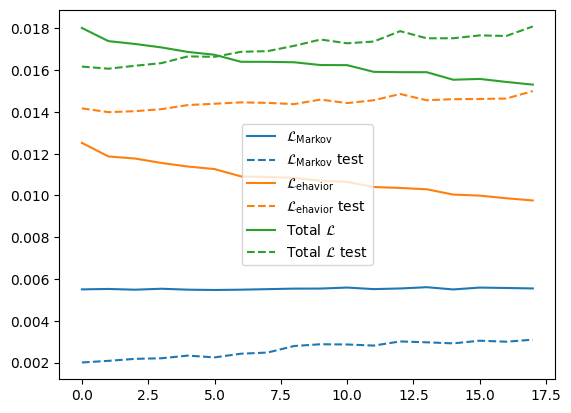

In [49]:
plt.figure()
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, label in enumerate([
    r"$\mathcal{L}_{\mathrm{Markov}}$",
    r"$\mathcal{L}_{\mathrm{ehavior}}$",
    r"Total $\mathcal{L}$"
]):
    plt.plot(train_history[:, i], label=label, c=colors[i])
    plt.plot(test_history[:, i], label=label + ' test', c=colors[i], linestyle='--')
plt.legend()

In [42]:
# Projecting into latent space
y0_tr = model.tau(x_train[:, 0]).numpy()
y1_tr = model.tau(x_train[:, 1]).numpy()

y0_tst = model.tau(x_test[:, 0]).numpy()
y1_tst = model.tau(x_test[:, 1]).numpy()

y0_ = model.tau(x_[:, 0]).numpy()
y1_ = model.tau(x_[:, 1]).numpy()

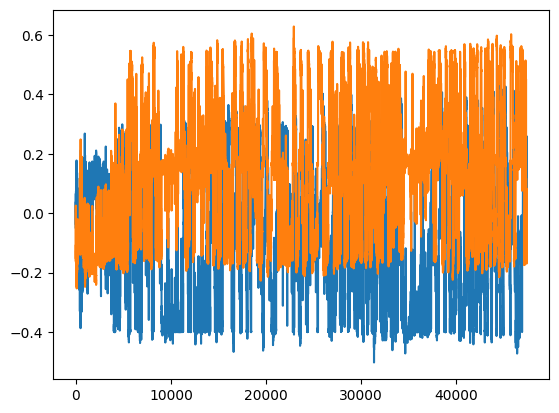

In [43]:
# %matplotlib notebook
plt.figure()
plt.plot(y0_)

In [44]:
y0_tr = np.c_[y0_tr, np.zeros_like(y0_tr[:,0])]
y1_tr = np.c_[y1_tr, np.zeros_like(y1_tr[:,0])]
y0_tst = np.c_[y0_tst, np.zeros_like(y0_tst[:,0])]
y1_tst = np.c_[y1_tst, np.zeros_like(y1_tst[:,0])]
y0_tr

array([[ 0.03537375, -0.15031582,  0.        ],
       [ 0.01525768,  0.02567337,  0.        ],
       [-0.00886602, -0.10224444,  0.        ],
       ...,
       [ 0.04563637, -0.14994977,  0.        ],
       [ 0.04313159, -0.14856306,  0.        ],
       [ 0.24839525,  0.06778777,  0.        ]], dtype=float32)

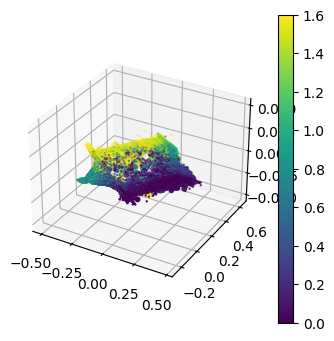

In [45]:
%matplotlib inline
# Continuous variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')
# ax.axis('off')
tr_pts = ax.scatter(y0_tr[:, 0], y0_tr[:, 1], y0_tr[:, 2], c=b_train_1[:, 0], s=0.5)
tst_pts = ax.scatter(y0_tst[:, 0], y0_tst[:, 1], y0_tst[:, 2], c=b_test_1[:, 0], s=10)
plt.colorbar(tr_pts)
plt.show()

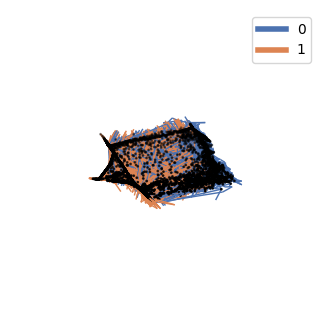

In [46]:
# Discrete variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

vis = LatentSpaceVisualiser(
    y=y0_tr,
    b=b_train_1[:, 1].astype(int),
    b_names=['0', '1']
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.0001)

vis = LatentSpaceVisualiser(
    y=y0_tst,
    b=b_test_1[:, 1].astype(int),
    b_names=['0', '1'],
    show_points=True
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.1)

plt.show()

In [29]:
save_data=True
if save_data:
    # Save the weights
    model.save_weights(f'../../data/generated/BunDLeNet_model_rat_{rat_name}')
    print(f'../../data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}')
    np.savetxt(f'../../data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}', y0_tr)
    np.savetxt(f'../../data/generated/saved_Y/y1_tr__{algorithm}_rat_{rat_name}', y1_tr)
    np.savetxt(f'../../data/generated/saved_Y/y0_tst__{algorithm}_rat_{rat_name}', y0_tst)
    np.savetxt(f'../../data/generated/saved_Y/y1_tst__{algorithm}_rat_{rat_name}', y1_tst)
    np.savetxt(f'../../data/generated/saved_Y/b_train_1__{algorithm}_rat_{rat_name}', b_train_1)
    np.savetxt(f'../../data/generated/saved_Y/b_test_1__{algorithm}_rat_{rat_name}', b_test_1)


../../data/generated/saved_Y/y0_tr__BunDLeNet_HPO_rat_cicero


/Users/aksheykumar/Desktop/comparison-algorithms/rat_embedding_evaluation/4_BunDLeNet
